In [2]:
import pickle
from pathlib import Path
import numpy as np
from typing import Dict
import pandas as pd
import os
from multiprocessing import cpu_count
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import Normalizer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [3]:
# Configuration
MALWARE_DIR = Path('malware_samples/')
MALWARE_TYPES = ['winwebsec', 'zbot', 'zeroaccess']
MAX_SAMPLES_PER_TYPE = 200
EMBEDDING_SIZE = 128
SAVED_MODELS_DIR = Path('saved_models/word2vec/')
os.makedirs(SAVED_MODELS_DIR, exist_ok=True)
NUM_CORES = cpu_count()

In [4]:
# Load embeddings
filename = SAVED_MODELS_DIR / 'mean_embedding_per_file.pkl'
with filename.open('rb') as f:
    mean_embeddings = pickle.load(f)

# Prepare data
embeddings, labels = [], []
for (malware_type, _), E in mean_embeddings.items():
    embeddings.append(E)
    labels.append(malware_type)

embeddings = np.array(embeddings)
labels = np.array(labels)

In [5]:
# Preprocess embeddings with L2 normalization for cosine distance
normalizer = Normalizer(norm='l2')
embeddings_normalized = normalizer.fit_transform(embeddings)

# DBSCAN clustering with cosine distance
dbscan = DBSCAN(
    eps=0.25,       # Maximum distance between samples in the same neighborhood
    min_samples=5,  # Minimum number of samples in a neighborhood
    metric='cosine',
    n_jobs=NUM_CORES
)
cluster_labels = dbscan.fit_predict(embeddings_normalized)

In [6]:
# Evaluation metrics
if len(np.unique(labels)) > 1:
    ari = adjusted_rand_score(labels, cluster_labels)
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}")

Adjusted Rand Index: 0.5538
Normalized Mutual Information: 0.7337


In [7]:
# Cluster analysis
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
n_noise = np.sum(cluster_labels == -1)

print(f"\nEstimated number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")


Estimated number of clusters: 2
Number of noise points: 0


In [8]:
# Detailed cluster breakdown
print("\nCluster composition:")
for cluster in unique_clusters:
    cluster_mask = cluster_labels == cluster
    cluster_name = f"Cluster {cluster}" if cluster != -1 else "Noise"
    type_counts = dict(zip(*np.unique(labels[cluster_mask], return_counts=True)))
    
    print(f"\n{cluster_name}:")
    for malware_type, count in type_counts.items():
        print(f"  {malware_type}: {count} samples")


Cluster composition:

Cluster 0:
  winwebsec: 10 samples
  zbot: 10 samples

Cluster 1:
  zeroaccess: 10 samples


/home/akoul/cs298/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-05 14:52:10.248409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 14:52:10.249625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 14:52:10.252020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 14:52:10.258367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory f

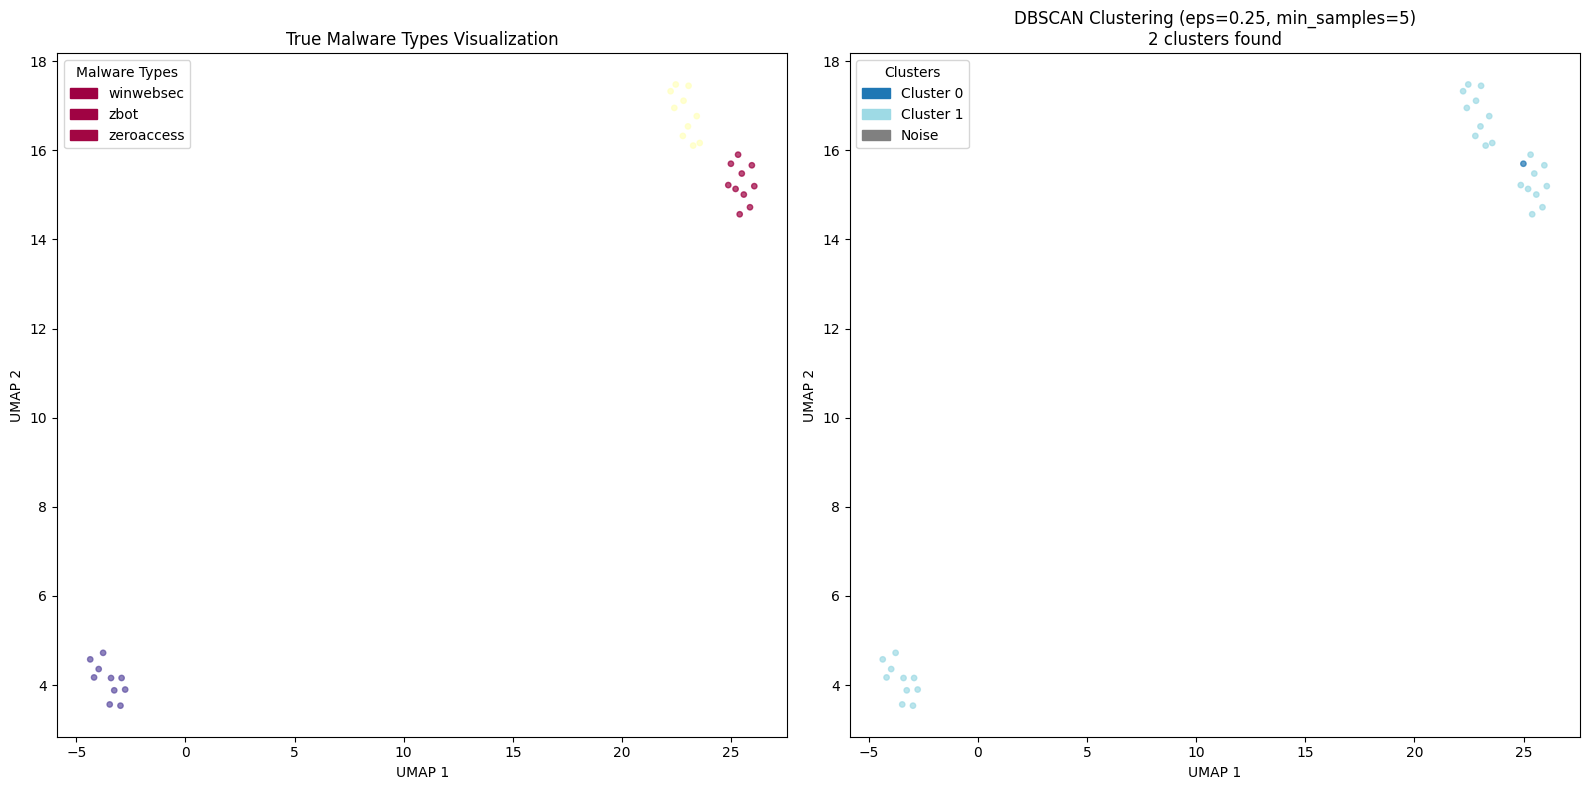

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap

# Dimensionality reduction for visualization
def reduce_dimensions(embeddings, method='umap', n_components=2):
    if method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    else:
        raise ValueError("Use 'umap' or 'pca'")
    return reducer.fit_transform(embeddings)

# Reduce to 2D using UMAP (preserves cluster structure better than PCA)
projected_embeddings = reduce_dimensions(embeddings_normalized, method='umap')

# Create figure with two subplots
plt.figure(figsize=(16, 8))

# Plot 1: True labels visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    projected_embeddings[:, 0], 
    projected_embeddings[:, 1], 
    c=pd.factorize(labels)[0], 
    cmap='Spectral',
    alpha=0.7,
    s=15
)
plt.title('True Malware Types Visualization')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
legend_labels = {i: label for i, label in enumerate(np.unique(labels))}
plt.legend(
    handles=[mpatches.Patch(color=scatter.cmap(i), label=label) 
             for i, label in legend_labels.items()],
    title='Malware Types'
)

# Plot 2: Cluster assignments visualization
plt.subplot(1, 2, 2)
unique_clusters = np.unique(cluster_labels)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

# Create colormap with distinct colors for clusters and gray for noise
cmap = plt.cm.get_cmap('tab20', n_clusters)
colors = [cmap(i) if label != -1 else (0.5, 0.5, 0.5, 0.5) 
          for i, label in enumerate(cluster_labels)]

plt.scatter(
    projected_embeddings[:, 0], 
    projected_embeddings[:, 1], 
    c=colors,
    alpha=0.7,
    s=15
)
plt.title(f'DBSCAN Clustering (eps=0.25, min_samples=5)\n{n_clusters} clusters found')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create legend for clusters
cluster_legend = [
    mpatches.Patch(color=cmap(i), label=f'Cluster {label}') 
    for i, label in enumerate(unique_clusters if -1 not in unique_clusters else unique_clusters[:-1])
]
noise_patch = mpatches.Patch(color=(0.5, 0.5, 0.5), label='Noise')
plt.legend(handles=cluster_legend + [noise_patch], title='Clusters')

plt.tight_layout()
plt.savefig(SAVED_MODELS_DIR / 'cluster_visualization.png', dpi=300)
plt.show()

/home/akoul/cs298/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


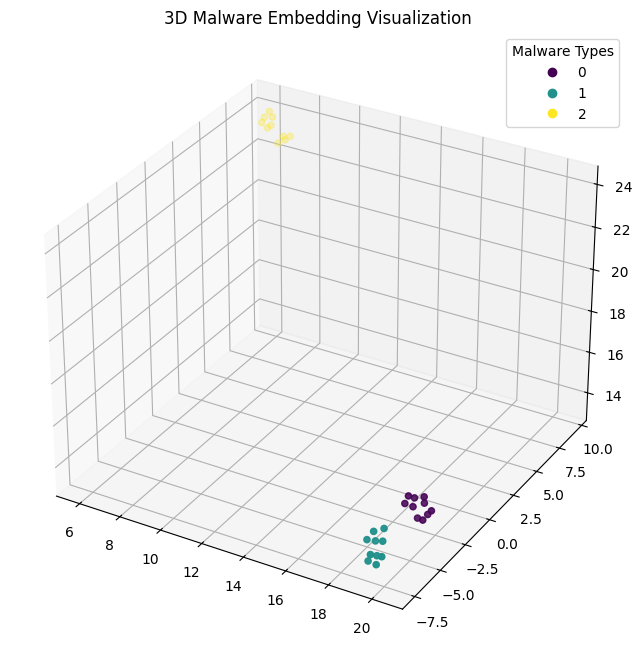

In [10]:
# 3D Visualization option
from mpl_toolkits.mplot3d import Axes3D

projected_3d = reduce_dimensions(embeddings_normalized, method='umap', n_components=3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter3D(
    projected_3d[:, 0], 
    projected_3d[:, 1], 
    projected_3d[:, 2], 
    c=pd.factorize(labels)[0],
    # cmap='Spectral',
    # alpha=0.7,
    # s=15
)
plt.title('3D Malware Embedding Visualization')
ax.legend(*scatter.legend_elements(), title='Malware Types')
plt.show()

Estimated number of clusters: 2
Estimated number of noise points: 0
Adjusted Rand Index: 1.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Silhouette Coefficient: 0.554


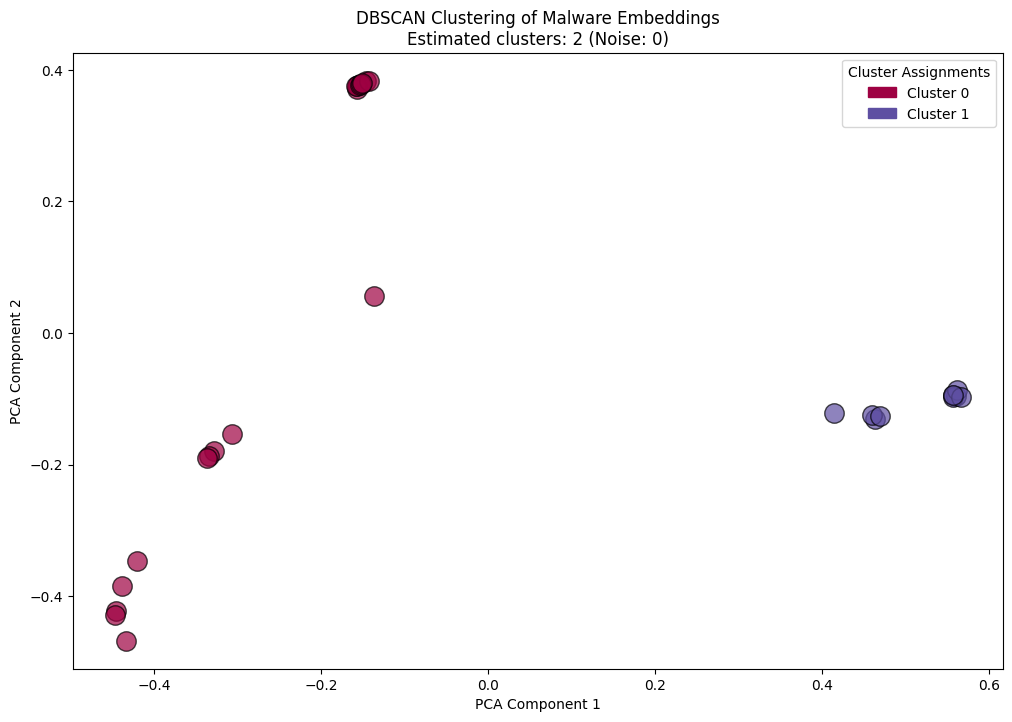

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA

# Reduce embeddings to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(embeddings_normalized)

# Compute DBSCAN and get core samples
db = DBSCAN(eps=0.25, min_samples=5, metric='cosine', n_jobs=NUM_CORES).fit(embeddings_normalized)
labels = db.labels_

# Calculate evaluation metrics
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels, cluster_labels):.3f}")
print(f"Homogeneity: {metrics.homogeneity_score(labels, cluster_labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels, cluster_labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels, cluster_labels):.3f}")
print(f"Silhouette Coefficient: {metrics.silhouette_score(embeddings_normalized, labels):.3f}")

# Plotting setup
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(12, 8))

# Color setup for malware types (use your actual label names)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black for noise
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    # Plot core samples
    xy = X_pca[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=14,
        alpha=0.7
    )

    # Plot non-core samples
    xy = X_pca[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        'o',
        markerfacecolor=tuple(col),
        markeredgecolor='k',
        markersize=6,
        alpha=0.7
    )

plt.title(f'DBSCAN Clustering of Malware Embeddings\nEstimated clusters: {n_clusters_} (Noise: {n_noise_})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Create legend with malware types
legend_handles = [
    mpatches.Patch(color=colors[i], label=f'Cluster {label}' if label != -1 else 'Noise')
    for i, label in enumerate(unique_labels)
]
plt.legend(handles=legend_handles, title='Cluster Assignments')

plt.show()